# Vegas Triple Attack Blackjack Switch (VTABS) Q-learning Model

In [1]:

import numpy as np
import pandas as pd
import random

# Load the dataset
file_path = "blkjckhands.csv"  # Ensure the dataset is in the same directory
df = pd.read_csv(file_path)

# Drop unnecessary columns
df_cleaned = df.drop(columns=["Unnamed: 0"])

# Convert categorical values to numerical
df_cleaned["winloss"] = df_cleaned["winloss"].map({"Win": 1, "Loss": 0})
df_cleaned["blkjck"] = df_cleaned["blkjck"].map({"win": 1, "nowin": 0})

# Fill missing values (if any)
df_cleaned.fillna(0, inplace=True)

# Convert relevant columns to integers
df_cleaned = df_cleaned.astype(int, errors='ignore')

# Define helper functions for action eligibility
def can_hit(sumofcards):
    return int(sumofcards < 21)

def can_stand():
    return 1

def can_split(card1, card2):
    return int(card1 == card2 and card1 != 0)

def can_swap(card2, card4):
    return int(card2 != card4 and card2 != 0 and card4 != 0)

# Add computed action columns
df_cleaned["can_hit"] = df_cleaned["sumofcards"].apply(can_hit)
df_cleaned["can_stand"] = can_stand()
df_cleaned["can_split"] = df_cleaned.apply(lambda x: can_split(x["card1"], x["card2"]), axis=1)
df_cleaned["can_swap"] = df_cleaned.apply(lambda x: can_swap(x["card2"], x["card4"]), axis=1)


In [2]:

# Define the state space (Player's hand total, Dealer's face-up card, Actions)
state_space_size = (32, 11)  # (Max sum of cards +1, Dealer's card +1)
action_space_size = 4  # (Hit, Stand, Split, Swap)

# Initialize Q-table with zeros
Q_table = np.zeros(state_space_size + (action_space_size,))

# Define Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Decay rate for epsilon
num_episodes = 2000  # Training episodes

# Define possible actions
ACTIONS = {
    0: "Hit",
    1: "Stand",
    2: "Split",
    3: "Swap",
}

# Define function to get possible actions for a given state
def get_valid_actions(player_sum, can_split, can_swap):
    valid_actions = [0, 1]  # Hit and Stand are always available
    if can_split:
        valid_actions.append(2)
    if can_swap:
        valid_actions.append(3)
    return valid_actions

# Define function to calculate rewards
def get_reward(player_sum, dealer_sum, bust, blackjack, winloss):
    if bust:
        return -2  # Bust penalty
    elif blackjack:
        return 2  # Blackjack bonus
    elif winloss == 1:  # Player won
        return 1
    elif winloss == 0:  # Player lost
        return -1
    return 0

# Training loop
for episode in range(num_episodes):
    sample = df_cleaned.sample(1).iloc[0]
    player_sum = min(sample["sumofcards"], 31)  # Clip to valid range
    dealer_face_up = min(sample["dealcard1"], 10)  # Clip to valid range
    can_split = sample["can_split"]
    can_swap = sample["can_swap"]

    valid_actions = get_valid_actions(player_sum, can_split, can_swap)

    done = False
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(valid_actions)  # Exploration
        else:
            action = np.argmax(Q_table[player_sum, dealer_face_up])  # Exploitation

        if action == 0:  # Hit
            new_card = random.randint(1, 11)
            player_sum += new_card
            player_sum = min(player_sum, 31)
            bust = player_sum > 21
            blackjack = player_sum == 21

        elif action == 1:  # Stand
            bust = False
            blackjack = False

        elif action == 2 and can_split:  # Split
            player_sum = max(player_sum // 2, 1)
            bust = False
            blackjack = False

        elif action == 3 and can_swap:  # Swap
            player_sum = player_sum
            bust = False
            blackjack = False

        reward = get_reward(player_sum, sample["sumofdeal"], bust, blackjack, sample["winloss"])
        next_valid_actions = get_valid_actions(player_sum, can_split, can_swap)

        if bust:
            Q_table[player_sum, dealer_face_up, action] = reward  # Terminal state
            done = True
        else:
            next_best_action = np.argmax(Q_table[player_sum, dealer_face_up]) if next_valid_actions else 1
            Q_table[player_sum, dealer_face_up, action] += alpha * (reward + gamma * Q_table[player_sum, dealer_face_up, next_best_action] - Q_table[player_sum, dealer_face_up, action])

        if action == 1 or bust:
            done = True

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Save trained Q-table
np.save("trained_q_table.npy", Q_table)


In [11]:

# Load trained Q-table
Q_table = np.load("trained_q_table.npy")

def choose_best_action(player_sum, dealer_face_up, can_split, can_swap):
    player_sum = min(player_sum, 31)
    dealer_face_up = min(dealer_face_up, 10)
    valid_actions = get_valid_actions(player_sum, can_split, can_swap)
    q_values = Q_table[player_sum, dealer_face_up]
    best_action = max(valid_actions, key=lambda action: q_values[action])
    return best_action, ACTIONS[best_action]

def simulate_blackjack_game():
    sample = df_cleaned.sample(1).iloc[0]
    player_sum = min(sample["sumofcards"], 31)
    dealer_face_up = min(sample["dealcard1"], 10)
    can_split = sample["can_split"]
    can_swap = sample["can_swap"]

    print(f"Starting Game: Player Sum = {player_sum}, Dealer Face-up = {dealer_face_up}")

    while True:
        best_action, action_name = choose_best_action(player_sum, dealer_face_up, can_split, can_swap)
        print(f"Player chooses to: {action_name}")

        if best_action == 0:
            new_card = random.randint(1, 11)
            player_sum += new_card
            player_sum = min(player_sum, 31)
            print(f"New card drawn: {new_card}, New total: {player_sum}")
            if player_sum > 21:
                print("Player BUSTS!")
                break

        elif best_action == 1:
            print("Player STANDS. Game over.")
            break

def run_multiple_simulations(n_games=10):
    simulation_results = []
    for game in range(n_games):
        sample = df_cleaned.sample(1).iloc[0]
        player_sum = min(sample["sumofcards"], 31)
        dealer_face_up = min(sample["dealcard1"], 10)
        can_split = sample["can_split"]
        can_swap = sample["can_swap"]

        game_log = [f"Game {game+1}: Player Sum = {player_sum}, Dealer Face-up = {dealer_face_up}"]

        while True:
            best_action, action_name = choose_best_action(player_sum, dealer_face_up, can_split, can_swap)
            game_log.append(f"Player chooses to: {action_name}")

            if best_action == 0:  # Hit
                new_card = random.randint(1, 11)
                player_sum += new_card
                player_sum = min(player_sum, 31)
                game_log.append(f"New card drawn: {new_card}, New total: {player_sum}")
                if player_sum > 21:
                    game_log.append("Player BUSTS!")
                    break

            elif best_action == 1:  # Stand
                game_log.append("Player STANDS. Game over.")
                break

        simulation_results.append("\n".join(game_log))

    return simulation_results

# Run simulations
sim_results = run_multiple_simulations(n_games=5) # Edit this to change the number of simulations you run
for result in sim_results:
    print(result)

Game 1: Player Sum = 21, Dealer Face-up = 9
Player chooses to: Hit
New card drawn: 4, New total: 25
Player BUSTS!
Game 2: Player Sum = 20, Dealer Face-up = 9
Player chooses to: Stand
Player STANDS. Game over.
Game 3: Player Sum = 19, Dealer Face-up = 3
Player chooses to: Hit
New card drawn: 8, New total: 27
Player BUSTS!
Game 4: Player Sum = 18, Dealer Face-up = 6
Player chooses to: Hit
New card drawn: 7, New total: 25
Player BUSTS!
Game 5: Player Sum = 13, Dealer Face-up = 5
Player chooses to: Hit
New card drawn: 11, New total: 24
Player BUSTS!


In [4]:
# Define the trained Q-table (This is a placeholder, load actual Q-table in practice)
Q_table = np.load("trained_q_table.npy")

# Display shape of Q-table
print("Q-table Shape:", Q_table.shape)

# Function to look up Q-values for a given state
def get_q_values(player_sum, dealer_face_up):
    player_sum = min(player_sum, 31)  # Clip to valid range
    dealer_face_up = min(dealer_face_up, 10)  # Clip to valid range
    return Q_table[player_sum, dealer_face_up]

# Example usage:
player_sum = 17
dealer_face_up = 10
print(f"Q-values for Player Sum = {player_sum}, Dealer Face-up = {dealer_face_up}:")
print(get_q_values(player_sum, dealer_face_up))


Q-table Shape: (32, 11, 4)
Q-values for Player Sum = 17, Dealer Face-up = 10:
[ 0.       -0.126559  0.        0.      ]


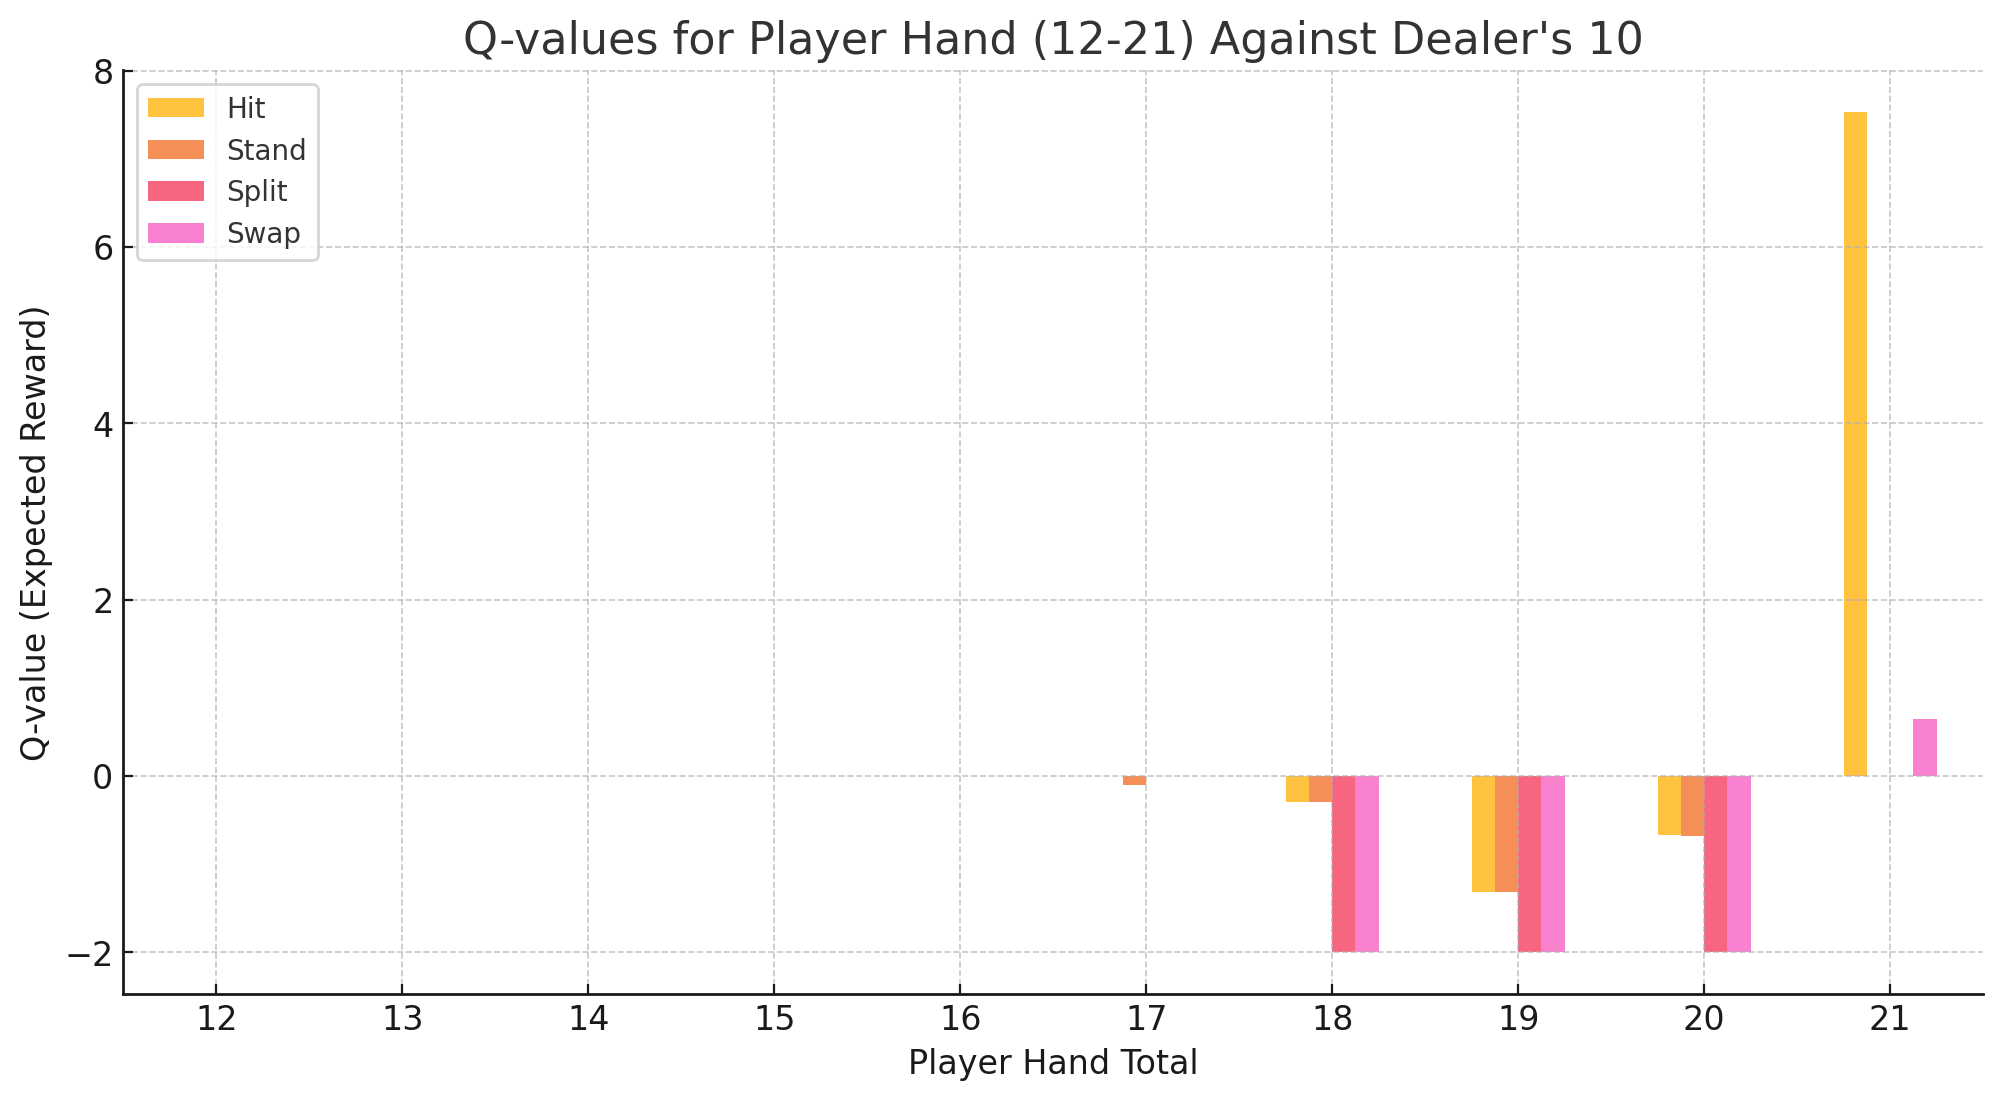

In [9]:

# Load the CSV file
file_path = "Q-values_Analysis.csv"  # Ensure the file is in the correct directory
df = pd.read_csv(file_path)

print(df)


        Hit     Stand  Split      Swap
0  0.000000  0.000000    0.0  0.000000
1  0.000000  0.000000    0.0  0.000000
2  0.000000  0.000000    0.0  0.000000
3  0.000000  0.000000    0.0  0.000000
4  0.000000  0.000000    0.0  0.000000
5  0.000000 -0.100000    0.0  0.000000
6 -0.292100 -0.297010   -2.0 -2.000000
7 -1.312542 -1.312542   -2.0 -2.000000
8 -0.666247 -0.679347   -2.0 -2.000000
9  7.529492  0.000000    0.0  0.646456
